# Project: Wrangling and Analyze Data

## Data Gathering

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline

1.Firstly we will directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
tweet_archive = pd.read_csv('twitter-archive-enhanced.csv')
tweet_archive.head(33)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [3]:
tweet_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
tweet_archive.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [5]:
tweet_archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [6]:
sum(tweet_archive.duplicated())

0

In [7]:
tweet_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

2. We will use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [8]:
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

open('image_predictions.tsv', 'wb').write(response.content)
image_p = pd.read_csv('image_predictions.tsv', sep = '\t' )
image_p.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1853,840696689258311684,https://pbs.twimg.com/media/C6rBLenU0AAr8MN.jpg,1,web_site,0.841768,False,rule,0.007087,False,envelope,0.006820,False
2047,886736880519319552,https://pbs.twimg.com/media/DE5Se8FXcAAJFx4.jpg,1,kuvasz,0.309706,True,Great_Pyrenees,0.186136,True,Dandie_Dinmont,0.086346,True
1958,865359393868664832,https://pbs.twimg.com/media/DAJfxqGVoAAnvQt.jpg,2,Chesapeake_Bay_retriever,0.832435,True,Labrador_retriever,0.163551,True,Weimaraner,0.002770,True
260,670783437142401025,https://pbs.twimg.com/media/CU8Z-OxXAAA-sd2.jpg,1,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False
1467,778748913645780993,https://pbs.twimg.com/media/Cs6r_-kVIAALh1p.jpg,1,Staffordshire_bullterrier,0.351434,True,boxer,0.201478,True,American_Staffordshire_terrier,0.142838,True
1213,743222593470234624,https://pbs.twimg.com/media/ClB09z0WYAAA1jz.jpg,1,kuvasz,0.350629,True,soft-coated_wheaten_terrier,0.182782,True,golden_retriever,0.087662,True
1917,854732716440526848,https://pbs.twimg.com/media/C9ye3b3WAAAlTo0.jpg,1,Pembroke,0.695548,True,Cardigan,0.058902,True,chow,0.028411,True
94,667550882905632768,https://pbs.twimg.com/media/CUObvUJVEAAnYPF.jpg,1,web_site,0.998258,False,dishwasher,0.000201,False,oscilloscope,0.000142,False
1586,797971864723324932,https://pbs.twimg.com/media/CxL3IWeVEAAAIE2.jpg,1,American_Staffordshire_terrier,0.489845,True,Chihuahua,0.305760,True,Staffordshire_bullterrier,0.072799,True
1872,844979544864018432,https://pbs.twimg.com/media/C7n4aQ0VAAAohkL.jpg,3,tennis_ball,0.999281,False,racket,0.000370,False,Shetland_sheepdog,0.000132,True


In [9]:
image_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [10]:
image_p.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [11]:
sum(image_p.duplicated())

0

In [12]:
image_p.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [13]:
tweet_archive.retweeted_status_id.isna().sum()

2175

3. We will use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [14]:
tweet_df = pd.read_json('tweet-json.json', lines=True)
tweet_df.sample(10)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
1025,NaN,NaN,2016-06-23 19:05:49,"[0, 83]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 746056674465751040, 'id_str'...",3904,False,This is Arlen and Thumpelina. They are best pa...,NaN,...,0.0,NaN,NaN,NaN,931,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
350,NaN,NaN,2017-02-14 02:02:51,"[0, 116]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 831322776149430272, 'id_str'...",10042,False,This is Pete. He has no eyes. Needs a guide do...,NaN,...,0.0,NaN,NaN,NaN,1744,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1873,NaN,NaN,2015-12-11 00:44:07,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 675113795468066816, 'id_str'...",2120,False,Meet Zuzu. He just graduated college. Astute p...,NaN,...,0.0,NaN,NaN,NaN,877,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
191,NaN,NaN,2017-04-22 16:18:34,"[0, 110]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,28056,False,I HEARD HE TIED HIS OWN BOWTIE MARK AND HE JUS...,NaN,...,0.0,{'created_at': 'Sat Apr 22 05:36:05 +0000 2017...,8.556564e+17,8.556564e+17,5943,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1504,NaN,NaN,2016-01-25 22:58:05,"[0, 75]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 691756951399591936, 'id_str'...",3179,False,THE BRITISH ARE COMING\nTHE BRITISH ARE COMING...,NaN,...,0.0,NaN,NaN,NaN,1161,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1417,NaN,NaN,2016-02-13 03:05:01,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 698341973569245184, 'id_str'...",2485,False,This is Maximus. He's training for the tetherb...,NaN,...,0.0,NaN,NaN,NaN,1074,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
385,NaN,NaN,2017-02-01 02:17:19,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: Please only send in dogs. We on...,NaN,...,NaN,NaN,NaN,NaN,4521,False,{'created_at': 'Sat Dec 17 00:38:52 +0000 2016...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1258,NaN,NaN,2016-03-17 00:58:46,"[0, 82]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 710269104096153601, 'id_str'...",2613,False,The squad is back for St. Patrick's Day! ☘ 💚\n...,NaN,...,0.0,NaN,NaN,NaN,1257,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
113,NaN,NaN,2017-06-02 15:00:16,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 870656293136216066, 'id_str'...",12819,False,This is Cody. He zoomed too aggressively and t...,NaN,...,0.0,NaN,NaN,NaN,2817,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1832,NaN,NaN,2015-12-13 19:30:01,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,2335,False,Here we are witnessing a very excited dog. Cle...,NaN,...,0.0,NaN,NaN,NaN,1297,False,NaN,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [15]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [16]:
tweet_df.isna().sum()

contributors                     2354
coordinates                      2354
created_at                          0
display_text_range                  0
entities                            0
extended_entities                 281
favorite_count                      0
favorited                           0
full_text                           0
geo                              2354
id                                  0
id_str                              0
in_reply_to_screen_name          2276
in_reply_to_status_id            2276
in_reply_to_status_id_str        2276
in_reply_to_user_id              2276
in_reply_to_user_id_str          2276
is_quote_status                     0
lang                                0
place                            2353
possibly_sensitive                143
possibly_sensitive_appealable     143
quoted_status                    2326
quoted_status_id                 2325
quoted_status_id_str             2325
retweet_count                       0
retweeted   

## Assessing Data
In this section, we will be assessing the gathered data to detect and document  eight (8) quality issues and two (2) tidiness issue using visual and
programmatic assessement


### Quality issues

1. Missing data on multiple columns (retweeted_status_timestamp,retweeted_status_user_id, retweeted_status_id, in_reply_to_status_id, in_reply_to_user_id, expanded_urls)
2. Erroneous datatype (retweeted_status_timestamp and timestamp )

3. Inaccurate data on name column (a, such, quite)

4. Inaccurate data on the rating_numerator column (420, 666, 960)

5. Dogs names are not standardised

6. Irrelevant columns in the tweet json dataset and the twitter archive dataset

7. Inconsistent column names

8. There are retweets in the dataset

### Tidiness issues
1. Disjoint Datasets

2. The dog stages should be in one column instead of 4 different columns


## Cleaning Data
In this section, we will clean all the issues we documented while assessing. 

In [37]:
# copies of original pieces of data
tweet_archive_copy = tweet_archive.copy()
image_p_copy = image_p.copy()
tweet_df_copy = tweet_df.copy()

## Quality Issues

### Issue #1: Erroneous datatype (retweeted_status_timestamp and timestamp )

#### Define: 

<ol><li>We will change the retweeted_status_timestamp and timestamp datatypes to date

#### Code

In [45]:
# Converting datatypes
tweet_archive_copy['timestamp'] = pd.to_datetime(tweet_archive['timestamp'])
tweet_archive_copy['retweeted_status_timestamp'] = pd.to_datetime(tweet_archive['retweeted_status_timestamp'])

#### Test

In [19]:
tweet_archive_copy.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp    datetime64[ns]
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
dtype: object

### Issue #2: Inaccurate data on name column

#### Define: 

<ol><li>We will first make a list of all the names without meaning in the name column 
    <li>then replace all those names with 'None'

#### Code

In [46]:
#Collecting all names without meaning
names = tweet_archive_copy[tweet_archive_copy.name.str.islower()==True]['name']

In [47]:
names.value_counts()

a               55
the              8
an               7
very             5
just             4
quite            4
one              4
actually         2
not              2
getting          2
mad              2
infuriating      1
his              1
space            1
such             1
my               1
life             1
by               1
all              1
old              1
light            1
officially       1
incredibly       1
this             1
unacceptable     1
Name: name, dtype: int64

In [48]:
# Placing all the names we've collected inside the 'bad_name' list
bad_names = []
for n in names:
    if n not in bad_names:
        bad_names.append(n)
bad_names

['such',
 'a',
 'quite',
 'not',
 'one',
 'incredibly',
 'mad',
 'an',
 'very',
 'just',
 'my',
 'his',
 'actually',
 'getting',
 'this',
 'unacceptable',
 'all',
 'old',
 'infuriating',
 'the',
 'by',
 'officially',
 'life',
 'light',
 'space']

In [49]:
#Replacing meaning less names with 'None'
for x in bad_names:
    tweet_archive_copy.name.replace(x, 'None', inplace=True)

#### Test

In [50]:
tweet_archive_copy[tweet_archive_copy.name.str.islower()==True]['name']

Series([], Name: name, dtype: object)

### Issue #3: Dogs names are not standardised

#### Define

<ol><li>We will capitalize the fist letter of dog names in column p1,p2,p3 in the image_predictions dataset

#### Code

In [51]:
image_p_copy.p1 = image_p_copy.p1.str.capitalize()
image_p_copy.p2 = image_p_copy.p2.str.capitalize()
image_p_copy.p3 = image_p_copy.p3.str.capitalize()

#### Test

In [52]:
image_p_copy.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1914,854120357044912130,https://pbs.twimg.com/media/C9px7jyVwAAnmwN.jpg,4,Black-and-tan_coonhound,0.854861,True,Doberman,0.050792,True,Bluetick,0.021762,True
1712,818588835076603904,https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg,1,Norwegian_elkhound,0.372202,True,Chesapeake_bay_retriever,0.137187,True,Malamute,0.071436,True
1280,750132105863102464,https://pbs.twimg.com/media/CmkBKuwWgAAamOI.jpg,1,Toy_poodle,0.478018,True,Miniature_poodle,0.207458,True,Croquet_ball,0.085879,False
1793,831262627380748289,https://pbs.twimg.com/media/C4k88lGVMAEKNzb.jpg,1,Cocker_spaniel,0.263323,True,Brittany_spaniel,0.200550,True,Doormat,0.193414,False
715,685547936038666240,https://pbs.twimg.com/media/CYOONfZW8AA7IOA.jpg,1,Web_site,0.923987,False,Oscilloscope,0.009712,False,Hand-held_computer,0.008769,False
475,675149409102012420,https://pbs.twimg.com/media/CV6czeEWEAEdChp.jpg,1,Chow,0.999876,True,Tibetan_mastiff,0.000059,True,Tibetan_terrier,0.000029,True
368,672968025906282496,https://pbs.twimg.com/media/CVbc2V2WsAE3-kn.jpg,1,Toy_poodle,0.678046,True,Miniature_poodle,0.160273,True,Airedale,0.065649,True
1435,773704687002451968,https://pbs.twimg.com/media/CrzATQqWAAEHq2t.jpg,2,Silky_terrier,0.324251,True,Yorkshire_terrier,0.181210,True,Airedale,0.133436,True
1316,755110668769038337,https://pbs.twimg.com/ext_tw_video_thumb/75511...,1,Labrador_retriever,0.708974,True,Golden_retriever,0.114314,True,Great_pyrenees,0.065813,True
241,670444955656130560,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,English_springer,0.403698,True,Brittany_spaniel,0.347609,True,Welsh_springer_spaniel,0.137186,True


### Issue #4: Irrelevant columns in the tweet json file

#### Define

We will drop every column that is irrelevant for our data analysis

#### Code

In [53]:
# Removing all the columns we do not need
tweet_df_copy = tweet_df_copy.drop(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorited',
       'full_text', 'geo', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],axis=1)

#### Test

In [54]:
tweet_df_copy.columns

Index(['favorite_count', 'id', 'retweet_count'], dtype='object')

### Issue #5: Irrelevant columns in the twitter archive file ( retweeted_status_timestamp,retweeted_status_user_id, retweeted_status_id, in_reply_to_status_id,	in_reply_to_user_id, source)

#### Define

We will now remove irrelevant data on the twitter archive dataset

#### Code

In [55]:
tweet_archive_copy = tweet_archive_copy.drop(['retweeted_status_timestamp','retweeted_status_user_id','retweeted_status_id','in_reply_to_status_id','in_reply_to_user_id','source'],axis=1)

#### Test

In [56]:
tweet_archive_copy

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,
5,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,
6,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,
7,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,
8,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


### Issue #6: Inconsistent column names

#### Define

1. We will change column names in tweet_df to tweet_id

#### Code

In [57]:
tweet_df_copy.rename(columns = {'id':'tweet_id'}, inplace = True)

#### Test

In [58]:
tweet_df_copy.head()

,favorite_count,tweet_id,retweet_count
0,39467,892420643555336193,8853
1,33819,892177421306343426,6514
2,25461,891815181378084864,4328
3,42908,891689557279858688,8964
4,41048,891327558926688256,9774


### Issue #7: Retweets in the dataset

#### Define

We will remove retweets in our dataset using the "constains()" function

#### Code

In [59]:
# Dropping Retweets
tweet_archive_copy= tweet_archive_copy[tweet_archive_copy["text"].str.contains('RT @dog_rates:') == False]

#### Test

In [60]:
retweet = 'RT @dog_rates'
for x in tweet_archive_copy.text:
    if retweet in x:
        print(x)

## Tidiness Issues

### Issue #1: Dog stages in different columns instead of one

#### Define

create the 'dog stage' column by combining 'doggo', 'floofer', 'pupper' and 'puppo'

#### Code

In [35]:
tweet_archive_copy.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [38]:
tweet_archive_copy.doggo.replace('None','',inplace=True) 
tweet_archive_copy.floofer.replace('None','',inplace=True)
tweet_archive_copy.pupper.replace('None','',inplace=True) 
tweet_archive_copy.puppo.replace('None','',inplace=True)

In [39]:
tweet_archive_copy['stage'] = tweet_archive_copy.doggo +tweet_archive_copy.floofer + tweet_archive_copy.pupper + tweet_archive_copy.puppo

In [41]:
tweet_archive_copy.loc[tweet_archive_copy.stage == 'doggopupper', 'stage'] = 'doggo,pupper' 
tweet_archive_copy.loc[tweet_archive_copy.stage == 'doggopuppo', 'stage'] = 'doggo,puppo' 
tweet_archive_copy.loc[tweet_archive_copy.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'

In [42]:
tweet_archive_copy.drop(['doggo', 'floofer','pupper','puppo'],axis=1,inplace=True)

#### Test

In [43]:
tweet_archive_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'stage'],
      dtype='object')

### Issue #2: Disjoint Datasets

#### Define

Now we will combine the 3 datasets

#### Code

In [61]:
twitter_df = pd.merge(tweet_archive_copy,image_p_copy,on=['tweet_id'],how='inner')
twitter_df = pd.merge(twitter_df,tweet_df_copy,on=['tweet_id'],how='inner')

#### Test

In [62]:
twitter_df

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,39467,8853
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,33819,6514
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,25461,4328
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador_retriever,0.168086,True,Spatula,0.040836,False,42908,8964
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048,9774
5,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,20562,3261
6,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,...,0.341703,True,Border_collie,0.199287,True,Ice_lolly,0.193548,False,12041,2158
7,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,...,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,56848,16716
8,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,...,0.487574,True,Irish_setter,0.193054,True,Chesapeake_bay_retriever,0.118184,True,28226,4429
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,...,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,32467,7711


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [63]:
twitter_df.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize our wrangled data.

In [64]:
twitter_df.head(10)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,39467,8853
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,33819,6514
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,25461,4328
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador_retriever,0.168086,True,Spatula,0.040836,False,42908,8964
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048,9774
5,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,20562,3261
6,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,...,0.341703,True,Border_collie,0.199287,True,Ice_lolly,0.193548,False,12041,2158
7,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,...,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,56848,16716
8,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,...,0.487574,True,Irish_setter,0.193054,True,Chesapeake_bay_retriever,0.118184,True,28226,4429
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,...,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,32467,7711


In [65]:
twitter_df.groupby(['p1','p2','p3']).nunique()

tweet_id  \
p1                             p2                             p3                                         
Acorn_squash                   Shih-tzu                       Lhasa                                  1   
                               Toilet_seat                    Toy_poodle                             1   
Afghan_hound                   Basset                         Siberian_husky                         1   
                               Borzoi                         Doormat                                1   
                               Saluki                         Bloodhound                             1   
African_crocodile              American_alligator             Mink                                   1   
African_grey                   Madagascar_cat                 Television                             1   
African_hunting_dog            Plow                           Scottish_deerhound                     1   
Agama                          Gila_monster                   Lumbermill                             1   
Airedale                       Border_terrier                 Toy_poodle                             1   
                               Brown_bear                     Chesapeake_bay_retriever               1   
                               Cocker_spaniel                 Irish_terrier                          1   
                               Irish_terrier                  Bloodhound                             1   
                                                              Lakeland_terrier                       3   
                                                              Otterhound                             1   
                               Kerry_blue_terrier             Lakeland_terrier                       1   
                               Norfolk_terrier                Lakeland_terrier                       1   
                               Silky_terrier                  Lakeland_terrier                       1   
                               Toy_poodle                     Teddy                                  1   
Alp                            Lawn_mower                     Viaduct                                1   
American_black_bear            Lesser_panda                   Titi                                   1   
American_staffordshire_terrier Chesapeake_bay_retriever       Doberman                               1   
                               Chihuahua                      Staffordshire_bullterrier              1   
                               French_bulldog                 Staffordshire_bullterrier              1   
                               Labrador_retriever             Weimaraner                             1   
                               Staffordshire_bullterrier      Boxer                                  1   
                                                              Bull_mastiff                           3   
                                                              Chihuahua                              2   
                                                              Dalmatian                              1   
                                                              Italian_greyhound                      1   
...                                                                                                ...   
Whippet                        Great_dane                     Boxer                                  1   
                               Ibizan_hound                   Italian_greyhound                      1   
                               Italian_greyhound              American_staffordshire_terrier         2   
                                                              English_foxhound                       1   
                                                              Mexican_hairless                       1   
White_wolf                     American_staffordshire_terrier Ding

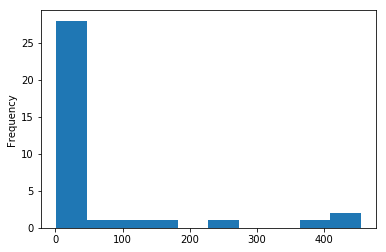

In [66]:
twitter_df.rating_numerator.value_counts().plot.hist();

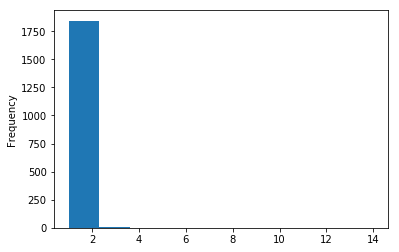

In [67]:
twitter_df.favorite_count.value_counts().plot.hist();

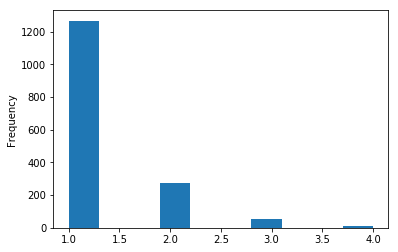

In [68]:
twitter_df.retweet_count.value_counts().plot.hist();

### Insights:
1. When ratings increase, the amount of likes(favorite_count) also increases

2. When the amount of likes increases, the number of retweets will also increase

3. Dogs in the doggo category got more likes and retweets

### Visualization

In [69]:
def label_graph(title,xlabel,ylabel):   # the functions purpose is to label graphs we will be using to visualise our data in this section
        plt.title('{}'.format(title))
        plt.xlabel('{}'.format(xlabel))
        plt.ylabel('{}'.format(ylabel))
        plt.legend();

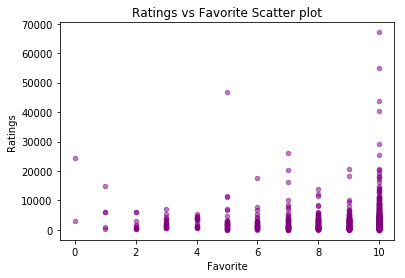

In [70]:
twitter_df.query('rating_numerator<=10').plot(kind='scatter', x='rating_numerator', y='favorite_count', alpha = 0.5, color = 'Purple')
plt.xlabel('Ratings')
label_graph('Ratings vs Favorite Scatter plot','Favorite','Ratings')